## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [34]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [35]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [36]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [37]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [38]:
#Estos son los 20 paises con más muertes del mundo.
df_20 = df.groupby("location").sum().sort_values(by="total_deaths", ascending=False)[5:].head(20)
df_20

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
location,,,,,,,,,,,,,,,,,,,,,
United States,6.816813e+09,33554274.0,3.352243e+07,137376731.0,602092.0,601318.856,2.059444e+07,101371.621,101275.410,415032.118,...,620.4,78113.013,5578.43,9874.7,12718.2,0.000,1432.09,40770.62,478.742,1395.89
Asia,7.799983e+09,53762740.0,5.337278e+07,121314030.0,768521.0,760389.418,1.681086e+06,11587.174,11503.126,26146.118,...,0.0,0.000,0.00,0.0,0.0,0.000,0.00,0.00,0.000,0.00
Brazil,3.049861e+09,17966831.0,1.777777e+07,83711355.0,502586.0,497729.006,1.434828e+07,84526.157,83636.724,393825.682,...,1638.8,85777.202,3909.02,4868.2,8627.8,0.000,1060.40,36574.16,368.730,527.20
India,3.898052e+09,29977861.0,2.981637e+07,52749578.0,389302.0,384892.580,2.824667e+06,21723.017,21606.003,38224.204,...,10790.8,143680.520,5288.51,967.1,10485.4,30310.950,269.77,35456.94,328.305,0.00
Mexico,5.167279e+08,2478551.0,2.469990e+06,48277352.0,231244.0,230884.727,4.007732e+06,19223.599,19157.188,374438.227,...,1345.0,82197.254,7026.28,3712.2,11513.2,47261.686,742.44,40376.90,419.102,3862.98
Peru,4.069757e+08,2030611.0,2.019763e+06,39666249.0,190645.0,189854.859,1.234313e+07,61586.210,61257.189,1203033.906,...,1865.5,45707.415,3171.35,2558.4,0.0,0.000,852.80,40902.42,414.141,10415.89
United Kingdom,8.881682e+08,4656536.0,4.626559e+06,31875998.0,128245.0,128216.992,1.308323e+07,68593.464,68151.898,469551.847,...,101.6,62045.596,2174.24,10160.0,12547.6,0.000,1290.32,41310.56,473.456,902.23
Italy,7.341672e+08,4253460.0,4.250663e+06,28916644.0,127291.0,127211.859,1.214266e+07,70349.509,70303.257,478262.820,...,1016.0,57480.708,2428.24,10058.4,14122.4,0.000,1615.44,42423.08,453.136,955.12
Africa,1.006488e+09,5225099.0,5.153176e+06,25800681.0,137954.0,136686.569,7.507753e+05,3897.603,3843.923,19245.648,...,0.0,0.000,0.00,0.0,0.0,0.000,0.00,0.00,0.000,0.00


In [39]:
#El primero es el país que me toca según la propuesta del ejercicio. Si se encuentra dentro de df_20, utilizaré sus valores. Sino, cogeré los de España.
search ="M"
bool_series = df["location"].str.startswith(search, na = False)
df2 = df[bool_series]

df2 = df2.groupby("location").sum().sort_values(by="total_deaths", ascending=False)

df2.head(1)

#Ha salido México, 6ta posición mundial, es una referencia válida para el ejercicio.

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
location,,,,,,,,,,,,,,,,,,,,,
Mexico,516727928.0,2478551.0,2469990.003,48277352.0,231244.0,230884.727,4007732.065,19223.599,19157.188,374438.227,...,1345.0,82197.254,7026.28,3712.2,11513.2,47261.686,742.44,40376.9,419.102,3862.98


In [40]:
#Preparo la tabla como me dice el enunciado: índice, columnas, location:país.
data = df[["location","new_cases","new_deaths","population","total_deaths", "total_cases"]]

data.set_index(df["date"], inplace=True)
data = data[data["location"] == "Mexico"]
data = data.drop(columns="location")
data = data.fillna(0)
print(data.shape)
data

(538, 5)


,new_cases,new_deaths,population,total_deaths,total_cases
date,,,,,
2020-01-01,0.0,0.0,128932753.0,0.0,0.0
2020-01-02,0.0,0.0,128932753.0,0.0,0.0
2020-01-03,0.0,0.0,128932753.0,0.0,0.0
2020-01-04,0.0,0.0,128932753.0,0.0,0.0
2020-01-05,0.0,0.0,128932753.0,0.0,0.0
...,...,...,...,...,...
2021-06-17,4253.0,168.0,128932753.0,230792.0,2467643.0
2021-06-18,4098.0,167.0,128932753.0,230959.0,2471741.0
2021-06-19,0.0,0.0,128932753.0,230959.0,2471741.0


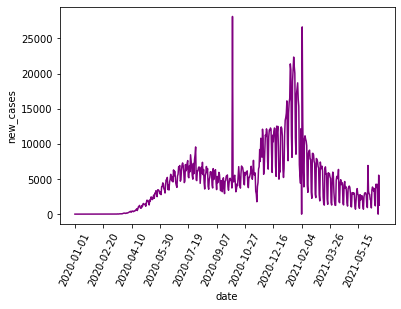

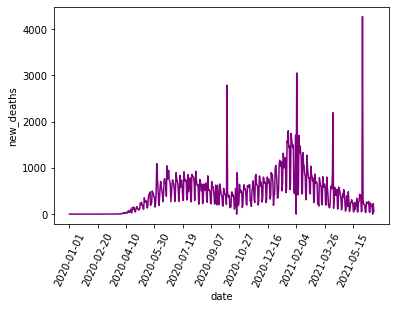

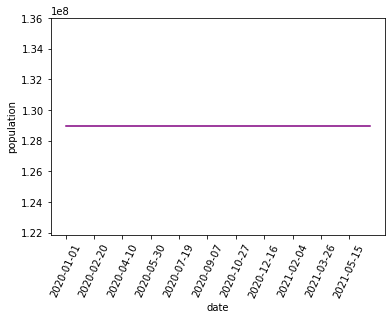

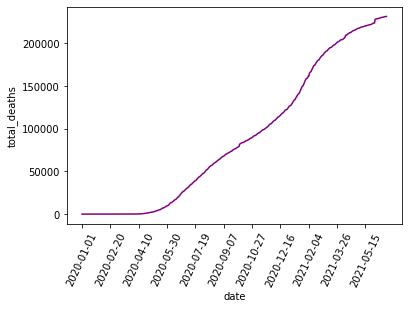

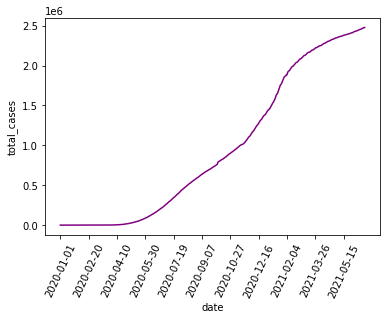

In [41]:
#Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.
for i in range(5):
    no_ticks = range(0,len(data),50)
    sns.lineplot(x=data.index, y=data.iloc[:,i], size_order=5, color="purple")
    plt.xticks(ticks=no_ticks, rotation=65)
    plt.show()

In [42]:
#Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

In [43]:
X = data[["total_deaths", "total_cases"]]

y1 = data["new_cases"]

y2 = data["new_deaths"]

In [44]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, test_size=0.2, random_state=42)


In [45]:
cv = RepeatedStratifiedKFold(n_splits=23, n_repeats=7, random_state=1)

pipe = Pipeline(steps=[
    ('reg', LinearRegression())
])

tree_params = {
    'reg': [DecisionTreeRegressor()],
}

svr_params = {
    'reg': [SVR()],
}

lin_params = {
    'reg': [LinearRegression()],
}



search_space = [
    tree_params,
    svr_params,
    lin_params
]

model = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = cv,
                  verbose=1,
                  n_jobs=-1,
                  return_train_score= True)


In [46]:
model.fit(X_train_1,y_train_1)

Fitting 161 folds for each of 3 candidates, totalling 483 fits
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=23.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=23.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=23.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=7, n_splits=23, random_state=1),
             estimator=Pipeline(steps=[('reg', LinearRegression())]), n_jobs=-1,
             param_grid=[{'reg': [DecisionTreeRegressor()]}, {'reg': [SVR()]},
                         {'reg': [LinearRegression()]}],
             return_train_score=True, verbose=1)

In [47]:
print(model.best_estimator_)
print(model.best_params_)
print(model.best_score_)

Pipeline(steps=[('reg', DecisionTreeRegressor())])
{'reg': DecisionTreeRegressor()}
0.6900673395968737


In [76]:
a = pd.DataFrame(model.cv_results_)
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split153_train_score,split154_train_score,split155_train_score,split156_train_score,split157_train_score,split158_train_score,split159_train_score,split160_train_score,mean_train_score,std_train_score
0,0.004262,0.003725,0.002348,0.001184,DecisionTreeRegressor(),{'reg': DecisionTreeRegressor()},0.669104,0.207796,0.379765,0.698419,...,0.981089,0.981689,0.981297,0.981903,0.999828,0.982092,0.981809,0.981730,0.982992,0.005254
1,0.019420,0.010338,0.005235,0.005803,SVR(),{'reg': SVR()},0.021926,-0.084010,0.097677,0.069524,...,0.040052,0.043367,0.046572,0.044259,0.046743,0.041202,0.043623,0.044859,0.043625,0.005657
2,0.003940,0.004675,0.002429,0.001602,LinearRegression(),{'reg': LinearRegression()},0.149549,0.164440,0.159570,0.246884,...,0.112380,0.130563,0.119542,0.131926,0.133949,0.123890,0.131523,0.132051,0.126948,0.007730


In [49]:
model.fit(X_train_2,y_train_2)

Fitting 161 folds for each of 3 candidates, totalling 483 fits
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=23.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=23.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=23.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=7, n_splits=23, random_state=1),
             estimator=Pipeline(steps=[('reg', LinearRegression())]), n_jobs=-1,
             param_grid=[{'reg': [DecisionTreeRegressor()]}, {'reg': [SVR()]},
                         {'reg': [LinearRegression()]}],
             return_train_score=True, verbose=1)

In [50]:
print(model.best_estimator_)
print(model.best_params_)
print(model.best_score_)

Pipeline(steps=[('reg', DecisionTreeRegressor())])
{'reg': DecisionTreeRegressor()}
0.3143143711389202


In [51]:
#Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

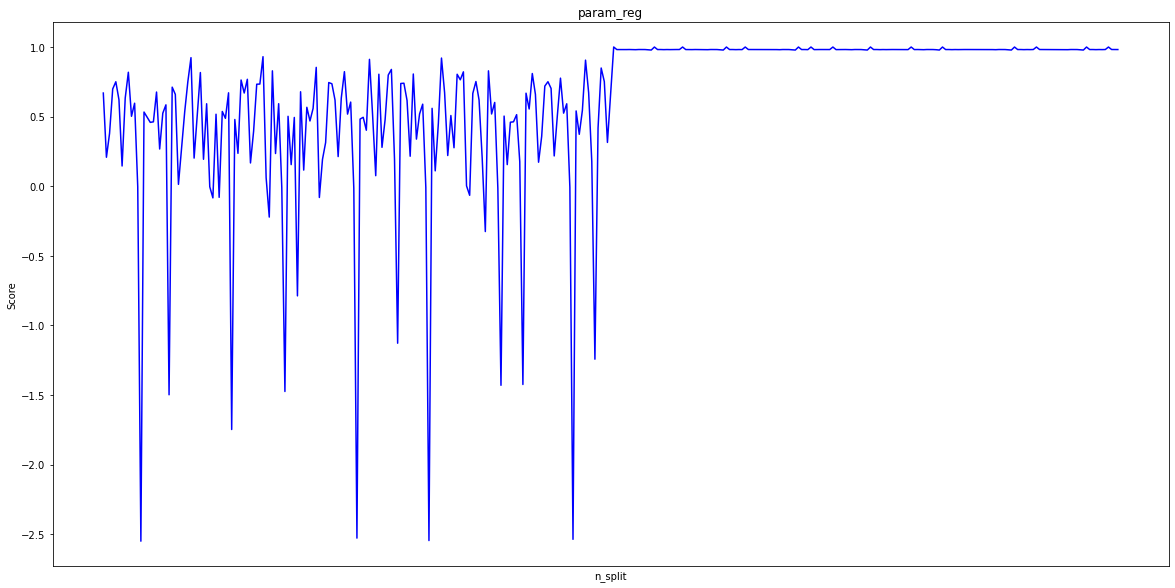

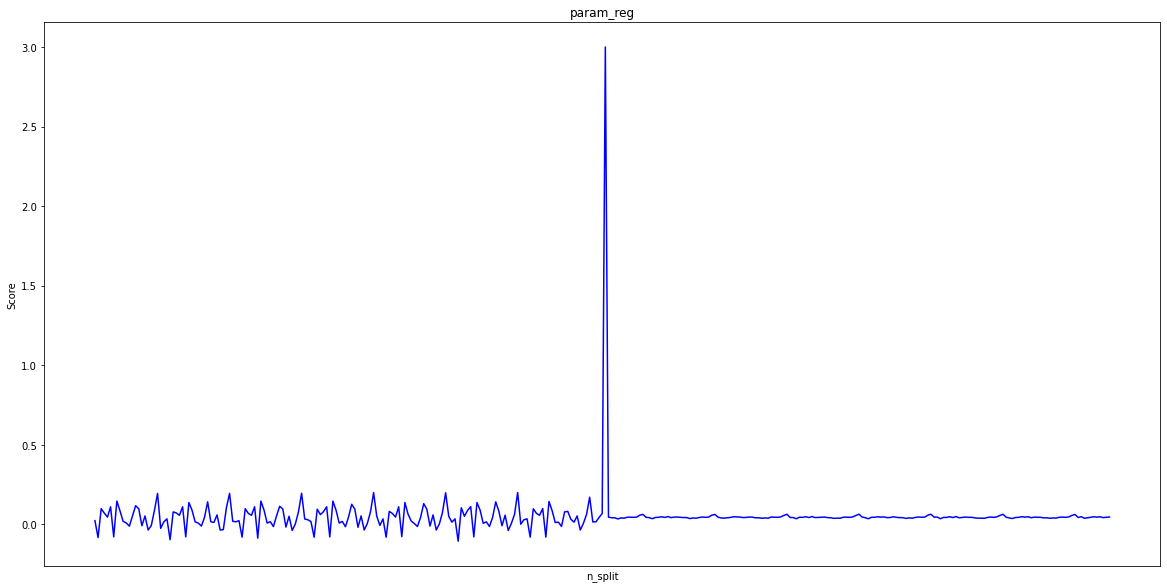

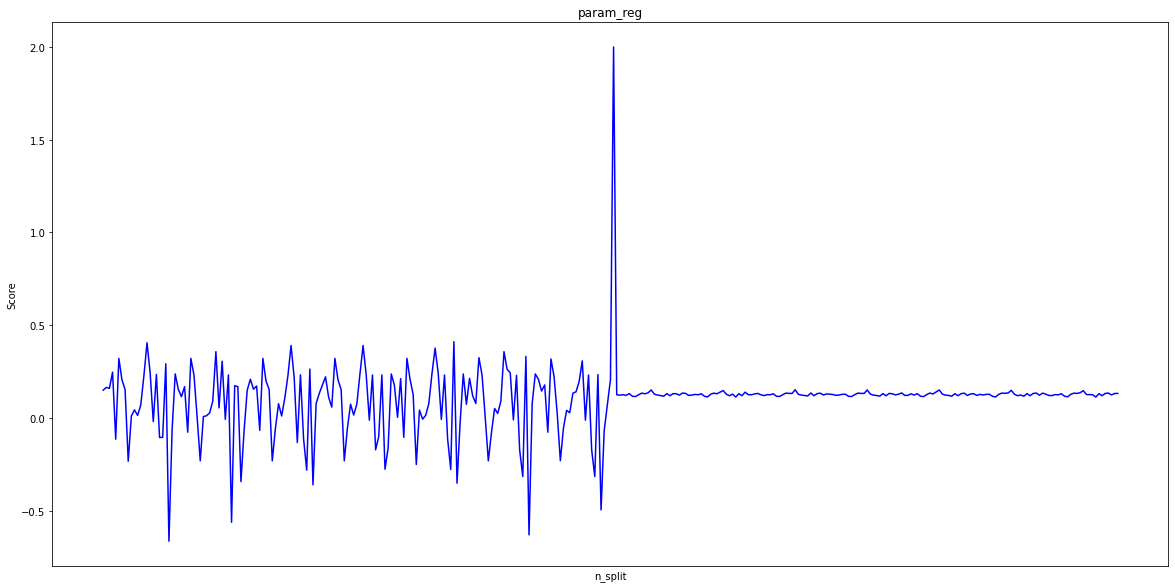

In [88]:
for x in range(3):    
    plt.figure(figsize=(20,10))
    plt.plot(a.iloc[:,6:331].iloc[x], color="b")
    plt.title(a.columns[4])
    plt.xticks(ticks=[])
    plt.ylabel("Score")
    plt.xlabel("n_split")

    plt.show()


In [ ]:
#Si, a mitad de tabla hay sobreentrenamiento.